In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

from epi.example_eps import euler_sim, euler_sim_traj, load_W
import tensorflow as tf

neuron_inds = {'E':0, 'P':1}
figdir = "./"

## Replicate results from Hennequin et al. 2018

In [2]:
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [6]:
# Dim is [M,N,|r|,T]
def euler_sim_stoch(f, x_init, dt, T):
    x = x_init
    for t in range(T):
        x = x + f(x) * dt
    return x[:, :, :, 0]

def euler_sim_stoch_traj(f, x_init, dt, T):
    x = x_init
    xs = [x_init]
    for t in range(T):
        x = x + f(x) * dt
        xs.append(x)
    return tf.concat(xs, axis=3)

In [7]:
V_INIT = tf.constant(-65.*np.ones((1,2,1), dtype=np.float32))

k = 0.3
n = 2.
v_rest = -70.

dt = 0.005

N = 20
T = 1000

def f_r(v):
    return k*(tf.nn.relu(v-v_rest)**n)

# Dim is [M,N,|r|,T]
def V1_sim_traj(h):
    D = 2
    h = h[:,None,:,None]

    W = np.array([[1.25, -0.65], [1.2, -0.5]], dtype=np.float32)
    W = tf.constant(W)
    sigma_eps = np.array([0.2, 0.1])
    tau = np.array([0.02, 0.01])
    tau_noise = np.array([0.05, 0.05])

    W = W[None,None,:,:]
    sigma_eps = sigma_eps[None,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]
    
    _v_shape = tf.ones((h.shape[0], N, D, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)
    
    def f(y):
        v = y[:,:,:D,:]
        eps = y[:,:,D:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))
       
        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise
        
        return tf.concat((dv, deps), axis=2)
        
    

    y_t = euler_sim_stoch_traj(f, y_init, dt, T)
    
    return y_t

def V1_stats(h):
    D = 2
    v_t = V1_sim_traj(h)[:,:,:D,:]
    r_t = v_t
    avg_r = tf.reduce_mean(r_t[:,:,:,(T//2):], axis=3)
    std_r = tf.math.reduce_std(r_t[:,:,:,(T//2):], axis=3)
    
    mean_avg_r = tf.reduce_mean(avg_r, axis=1)
    mean_std_r = tf.reduce_mean(std_r, axis=1)
    std_std_r = tf.math.reduce_std(std_r, axis=1)
    
    return tf.concat((mean_avg_r, mean_std_r, std_std_r), axis=1)



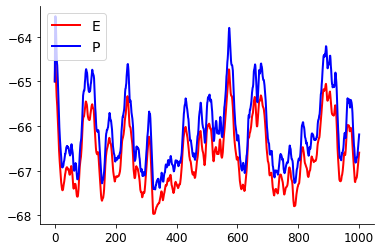

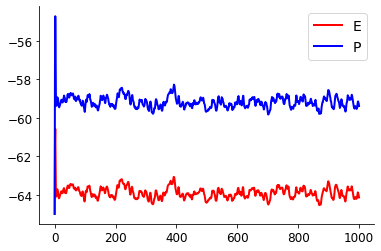

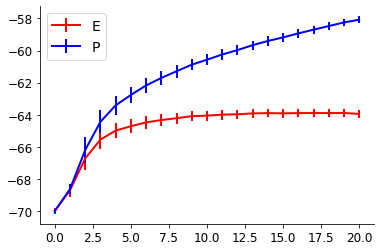

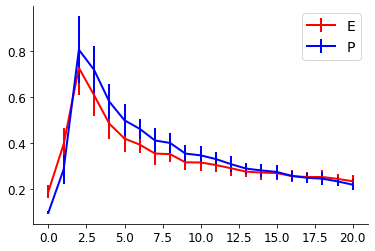

In [11]:
_h = np.linspace(0, 20, 21)
h = _h[:,None]*np.ones((1,2))
v_t = V1_sim_traj(h).numpy()
T_x = V1_stats(h)


plt.figure()
plt.plot(v_t[2,0,0,:], 'r', label='E')
plt.plot(v_t[2,0,1,:], 'b', label='P')
plt.legend()
plt.show()

plt.figure()
plt.plot(v_t[15,0,0,:], 'r', label='E')
plt.plot(v_t[15,0,1,:], 'b', label='P')
plt.legend()
plt.show()


plt.figure()
plt.errorbar(_h, T_x[:,0], T_x[:,2], c='r', label='E')
plt.errorbar(_h, T_x[:,1], T_x[:,3], c='b', label='P')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(_h, T_x[:,2], T_x[:,4], c='r', label='E')
plt.errorbar(_h, T_x[:,3], T_x[:,5], c='b', label='P')
plt.legend()
plt.show()